# **Clustering the Data**

## Objectives

* We will try many different numbers of clusters.

## Inputs

* The game data from before the train test split at the beginning of notebook 04. 

## Outputs

* A clustering model and some analysis of the underlying dataset.

## Additional Comments
* This notebook follow the analysis done in notebook 07 of the Churnometer walkthrough project.

---

# Change working directory
We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

home_dir = '/workspace/pp5-ml-dashboard'
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our prepared data.

In [2]:
import pandas as pd
from src.utils import get_df, save_df

game_data = get_df('game_pre_split', 'datasets/clean/csv')


## Section 1: Set up 
This notebook will be expedited and for personal use mostly. We will remove the season feature and then add it back when we are attempting to classify the clusters.



In [3]:
game_data.drop(labels=['season'],inplace=True,axis=1)
game_data.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
28500006,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
28500010,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
28500011,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
28500008,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


In [4]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from feature_engine import transformation as vt

TRANSFORM_ASSIGNMENT = {
    'yeo_johnson': ['dreb_away', 'blk_home', 'oreb_away', 'fta_away',
                    'dreb_home', 'ast_home', 'stl_away', 'pts_away',
                    'stl_home', 'reb_away', 'pts_home', 'fgm_away',
                    'oreb_home', 'pf_away', 'pf_home'],
    'box_cox': ['ast_away', 'fta_home']
    }
TRANSFORMS = {'box_cox':(vt.BoxCoxTransformer,False),
              'yeo_johnson':(vt.YeoJohnsonTransformer,False)}

def pipe_v1(thresh=0.7,p_components=50,clusters=50):
    pipe = Pipeline([
        ("corr_selector", SmartCorrelatedSelection(method="pearson",
                                                   threshold=thresh, 
                                                   selection_method="variance"))])
    pipe.fit(game_data)
    dropping = pipe['corr_selector'].features_to_drop_
    new_assignments = { key: [val for val in value if val not in dropping] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
    pipe.steps.append(('scaler', StandardScaler()))
    pipe.steps.append(("PCA", PCA(n_components=p_components, random_state=42)))
    pipe.steps.append(("model", KMeans(n_clusters=clusters, random_state=42)))
    return pipe



We will end up tuning the number of clusters and components as hyperparameters. It will be interesting to luck at how the analysis changes as we move between the number of clusters. At each stage, we will see how the function that assigns each game to its season behaves on clusters.

## Section 2: PCA
We start by doing some Principal component analysis.

In [5]:
# to suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logging.captureWarnings(True)
os.environ['PYTHONWARNINGS']='ignore'

pipe = pipe_v1()
pca_pipe = Pipeline(pipe.steps[:-2])
game_data_pca = pca_pipe.fit_transform(game_data)


We are now going to analyze the principal components. Feel free to adjust the number of components.

* The 15 components explain 97.89% of the data 



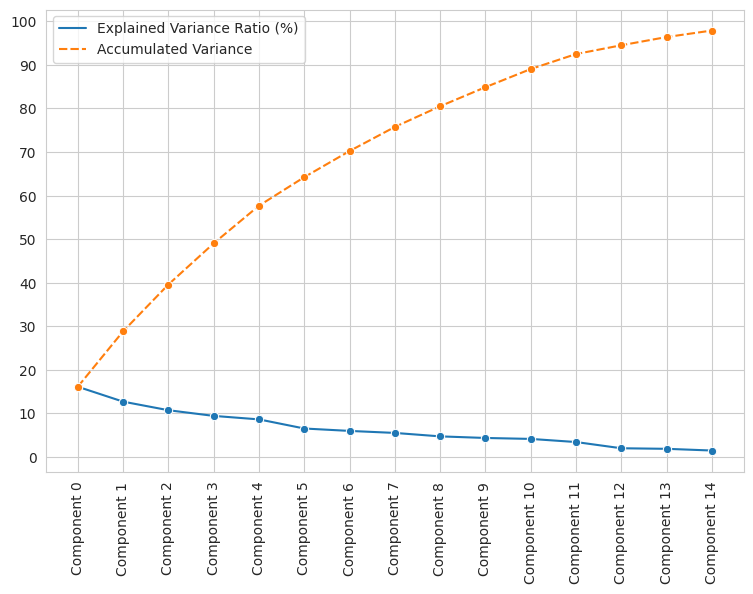

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# This function is from the notebook 07 of the 
# Churnometer walkthrough project.
def pca_component_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)

    ComponentsList = [f"Component {number}"
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )
    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )
    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_component_analysis(game_data_pca, 15)


As we are hoping the data will be grouped into eras, each of which is multiple years long. We expect there to be a fair number of clusters, so we don't mind having many components. We will try a variety of different number of components and clusters and look at the respective profiles.

So we redefine our pipeline creation function to have 9 as the number of components.

In [7]:
def pipe_9_comp(thresh=0.7,clusters=50):
    pipe = pipe_v1(thresh=thresh,p_components=9,clusters=clusters)
    return pipe

We will forgoe the elbow method. We will consider silhouette scores though, maybe.

In [8]:
new_pipe = pipe_9_comp()
pca_part_of_pipe = Pipeline(new_pipe.steps[:-1])
game_data_pca = pca_part_of_pipe.fit_transform(game_data)

In [9]:
'''from yellowbrick.cluster import KElbowVisualizer


# This is from notebook 07 of the 
# Churnometer walkthrough project.
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,11))
visualizer.fit(game_data_pca) 
visualizer.show() 
plt.show()
'''

'from yellowbrick.cluster import KElbowVisualizer\n\n\n# This is from notebook 07 of the \n# Churnometer walkthrough project.\nvisualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,11))\nvisualizer.fit(game_data_pca) \nvisualizer.show() \nplt.show()\n'

They are suggesting 4 clusters, but 6 also looks promising. Let's see how the Silhouette scores behave with respect to these different numbers of clusters.

In [10]:
'''from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start = 3
n_cluster_stop = 8

# This is from the notebook 07 of the 
# Churnometer walkthrough project.
print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(game_data_pca)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters,
                                                       random_state=42),
                                      colors='yellowbrick')
    visualizer.fit(game_data_pca)
    visualizer.show()
    plt.show()
    print("\n")

'''

'from yellowbrick.cluster import SilhouetteVisualizer\n\nn_cluster_start = 3\nn_cluster_stop = 8\n\n# This is from the notebook 07 of the \n# Churnometer walkthrough project.\nprint("=== Average Silhouette Score for different number of clusters ===")\nvisualizer = KElbowVisualizer(KMeans(random_state=42), k=(\n    n_cluster_start, n_cluster_stop), metric=\'silhouette\')\nvisualizer.fit(game_data_pca)\nvisualizer.show()\nplt.show()\nprint("\n")\n\n\nfor n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):\n\n    print(f"=== Silhouette plot for {n_clusters} Clusters ===")\n    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters,\n                                                       random_state=42),\n                                      colors=\'yellowbrick\')\n    visualizer.fit(game_data_pca)\n    visualizer.show()\n    plt.show()\n    print("\n")\n\n'

The analysis suggest using 3 clusters. After adding the clustering data to the dataframe we will see if the clustering correlates with the `season` feature.

We are taking into account some domain knowledge, which is that eras in basketball range from 6 to 10 years. It is not a well defined concept so we don't have a hard number. Our dataset ranges from 1985 until 2022. So we (conservatively) expect there to be between 4 and 7 eras. We will try clustering with respect to 3-9 clusters


In [11]:
pipes_9_comp = {}
game_many_clusters = {}
for i in range(3,10):
    key = f"clusters_{i}"
    pipes_9_comp[key]= pipe_9_comp(clusters=i)
    game_many_clusters[key] = game_data.copy()


Now we will fit all of these pipelines and see what they tell us.

In [12]:
for key, pipe in pipes_9_comp.items():
    pipe.fit(game_many_clusters[key])
    print("finished training ", key)
    

finished training  clusters_3
finished training  clusters_4
finished training  clusters_5
finished training  clusters_6
finished training  clusters_7
finished training  clusters_8
finished training  clusters_9


Let's add the clustering data to the dataframe.

In [13]:
for key, pipe in pipes_9_comp.items():
    game_many_clusters[key][key] = pipe.predict(game_many_clusters[key])

#game_w_clusters['Clusters'] = pipe_w_clusters.predict(game_data)

#game_w_clusters.head()

clusters_3
* Cluster frequencies 
   clusters_3
0        0.46
1        0.29
2        0.25 




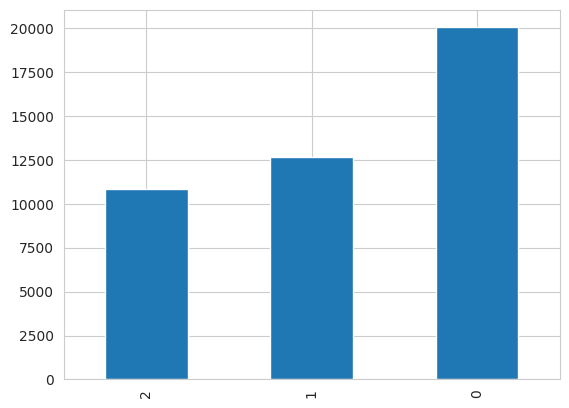

clusters_4
* Cluster frequencies 
   clusters_4
3        0.30
2        0.26
1        0.23
0        0.21 




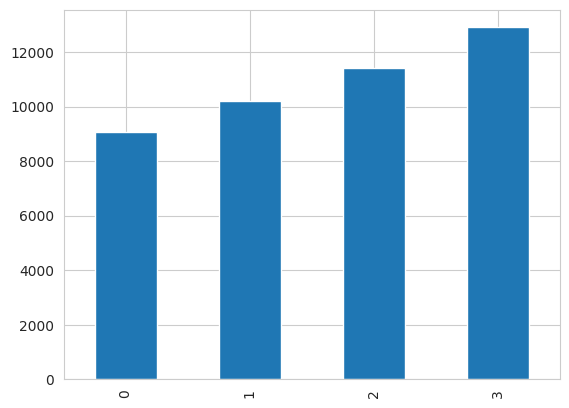

clusters_5
* Cluster frequencies 
   clusters_5
1        0.28
3        0.25
0        0.22
2        0.20
4        0.05 




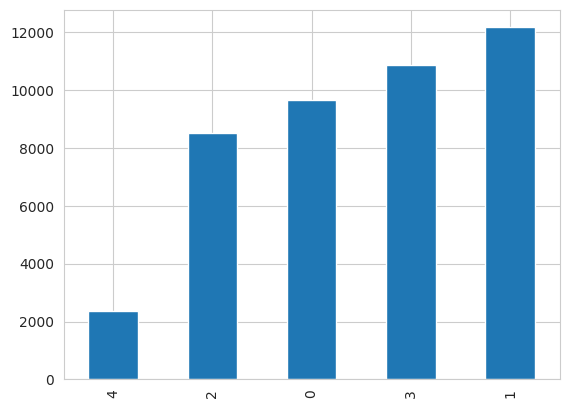

clusters_6
* Cluster frequencies 
   clusters_6
1        0.18
4        0.18
3        0.18
0        0.18
5        0.16
2        0.14 




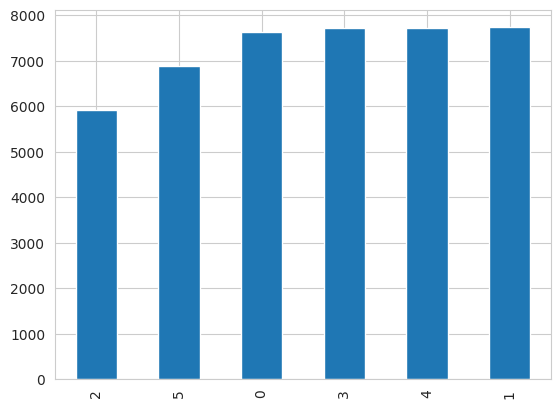

clusters_7
* Cluster frequencies 
   clusters_7
5        0.17
1        0.17
3        0.17
0        0.16
6        0.15
4        0.13
2        0.05 




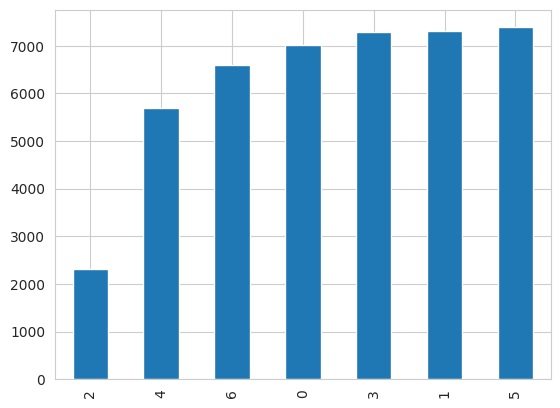

clusters_8
* Cluster frequencies 
   clusters_8
0        0.16
4        0.15
6        0.14
3        0.14
5        0.13
2        0.12
7        0.11
1        0.05 




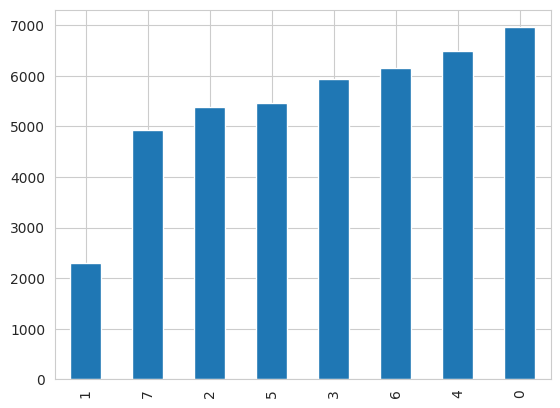

clusters_9
* Cluster frequencies 
   clusters_9
3        0.13
2        0.13
6        0.12
7        0.12
1        0.12
8        0.11
4        0.11
5        0.11
0        0.05 




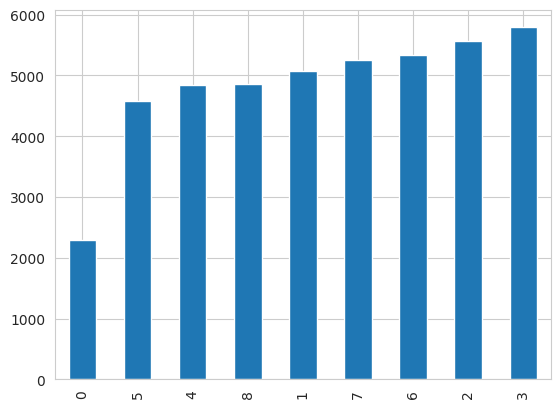

In [14]:
for key, value in game_many_clusters.items():
    print(key)
    print(f"* Cluster frequencies \n{value[key].value_counts(normalize=True).to_frame().round(2)} \n\n")
    value[key].value_counts().sort_values().plot(kind='bar')
    plt.show()

Let's add the season data back. We will see how the seasons are distributed across the clusters before training our classifcation model to get the profile of the individual clusters. Remember that the 1985-1986 season corresponds to 0 in the dataframe.

In [30]:
game_seasons = get_df('game_pre_split', 'datasets/clean/csv').filter(['season'])

for key,value in game_many_clusters.items():
    game_many_clusters[key] = value.join(game_seasons)

for key, value in game_many_clusters.items():
    if "season" not in value.columns:
         raise ValueError(f"soeason data not added to {key} df")



In [16]:
def season_per_cluster(df, key):
    cluster_num = int(key.split('_')[1])
    df = df.filter([key,"season"])
    print(key, cluster_num)
    print(type(key),type(cluster_num))
    print(df.columns)
    print(df.corr())
    for i in range(int(cluster_num)):
        cluster = df.query(f"{key} == {i}")
        fig, axes = plt.subplots(figsize=(9,5))
        sns.countplot(data=cluster, x='season').set_title(f"cluster {i} in {key}")
        plt.show           


In [22]:
'''print(game_many_clusters.keys())
for i in range(3,4):
    key = f"clusters_{i}"
    df = clusters_seasons[key]
    
    season_per_cluster(df, key)'''

'print(game_many_clusters.keys())\nfor i in range(3,4):\n    key = f"clusters_{i}"\n    df = clusters_seasons[key]\n    \n    season_per_cluster(df, key)'

In [32]:
for key, value in game_many_clusters.items():
    clusters_correlation = value.corr()
    print(key)
    print(clusters_correlation[key].sort_values(key=lambda x: abs(x), ascending=False)[:8])

clusters_3
clusters_3    1.000000
pts_away      0.526296
fga_away      0.515840
fga_home      0.497428
fg3a_away     0.486141
pts_home      0.485352
fg3a_home     0.472736
fgm_away      0.456621
Name: clusters_3, dtype: float64
clusters_4
clusters_4    1.000000
pts_away     -0.587439
fga_away     -0.516565
fgm_away     -0.513176
fga_home     -0.505301
ast_away     -0.396426
pts_home     -0.394616
fg3a_away    -0.393243
Name: clusters_4, dtype: float64
clusters_5
clusters_5         1.000000
home_wins         -0.441995
play_off           0.438730
plus_minus_home   -0.420944
pts_home          -0.416066
fgm_home          -0.415843
ast_home          -0.401821
season             0.351730
Name: clusters_5, dtype: float64
clusters_6
clusters_6    1.000000
oreb_away     0.417188
season       -0.386185
fg3m_home    -0.376459
fg3a_home    -0.369796
fg3a_away    -0.362463
fg3m_away    -0.312439
reb_away      0.308024
Name: clusters_6, dtype: float64
clusters_7
clusters_7         1.000000
pts_home 

Feel free to look at how other components compare with respect to the clusters. We felt these three were the most interesting.

## Section 4: Cluster Profile
We next wish to determine the profile of these clusters. We do this by training a classification model on the data (with season added back in) with the clusters as the target. The important features of the models will help us to determine the profiles of the individual clusters.

In our model selection notebook, we found that AdaBoost and Logistic Regression were good models for working with this data. We will use AdaBoost as it works on multi-class classification problems without any need for adjustment.

In [33]:
from sklearn.model_selection import train_test_split


X_train = {}
X_test = {}
y_train = {}
y_test = {}
for key, value in game_many_clusters.items():
    df = value.copy()
    split = train_test_split(
                    df.drop([key], axis=1),
                    df[key], test_size=0.2,
                    random_state=42)
    X_train[key] = split[0]
    X_test[key] = split[1]
    y_train[key] = split[2]
    y_test[key] = split[3]


Now we create our classifier pipeline. We will try it with the default parameters as well as the parameters we found in the last notebook.

In [35]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel

sample = X_train['clusters_4']
def clf_pipe(thresh=0.7, params={}):
    pipe = Pipeline([
        ('corr_selector',
         SmartCorrelatedSelection(method="pearson",
                                  threshold=thresh,
                                  selection_method="variance"))
                        ])
    pipe.fit(sample)
    dropping = pipe['corr_selector'].features_to_drop_
    new_assignments = { key: [val for val in value if val not in dropping] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
    pipe.steps.append(('scaler', StandardScaler()))
    model = AdaBoostClassifier(random_state=42,**params)
    pipe.steps.append(("feat_selection", SelectFromModel(model)))
    pipe.steps.append(('model',model))
    return pipe

ada_thresh = 0.8
ada_params = {'n_estimators': 110, 'learning_rate': 1.133,
              'algorithm': 'SAMME.R'}

Potentially, I could tune each of the pipes and get different parameters. I couold also see how the other models work.

In [36]:
tuned_pipes = {}
for key in X_train.keys():
    pipe = clf_pipe(thresh=ada_thresh, params=ada_params)
    pipe.fit(X_train[key], y_train[key])
    tuned_pipes[key] = pipe
    print(key)

clusters_3
clusters_4
clusters_5
clusters_6
clusters_7
clusters_8
clusters_9


In [37]:
from sklearn.metrics import classification_report


for key, pipe in tuned_pipes.items():
    print("="*30)
    print(f"{key} Tuned AdaBoost:")
    t_predicted_train = pipe.predict(X_train[key])
    t_predicted_test = pipe.predict(X_test[key])
    print("### Train Set ###")
    print(classification_report(y_train[key],t_predicted_train))
    print("### Test Set ###")
    print(classification_report(y_test[key],t_predicted_test))


clusters_3 Tuned AdaBoost:


### Train Set ###
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     16090
           1       0.95      0.92      0.93     10137
           2       0.94      0.96      0.95      8649

    accuracy                           0.95     34876
   macro avg       0.95      0.94      0.94     34876
weighted avg       0.95      0.95      0.95     34876

### Test Set ###
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3969
           1       0.95      0.92      0.93      2549
           2       0.94      0.95      0.95      2201

    accuracy                           0.95      8719
   macro avg       0.94      0.94      0.94      8719
weighted avg       0.95      0.95      0.95      8719

clusters_4 Tuned AdaBoost:
### Train Set ###
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      7240
           1       0.94      0.84      0.89      

It is very interesting how things drop off at 5 and at come back up at 6 then back down again at 7. I wonder if tuning hyper parameters would change this. We will only look at 3, 4, and 6, clusters.

The following features were dropped by clusters_3: 
['fgm_home', 'fg3m_home', 'ftm_home', 'pf_home', 'fgm_away', 'fg3m_away', 'dreb_home', 'stl_home', 'tov_home', 'plus_minus_home', 'ftm_away', 'fta_away', 'dreb_away', 'reb_away', 'stl_away', 'blk_away', 'pf_away', 'home_wins', 'play_off']

* These are the 15 most important features in descending order. The model was trained on them: 
['fga_home', 'fg3a_away', 'fg3a_home', 'oreb_away', 'fta_home', 'fga_away', 'pts_away', 'oreb_home', 'reb_home', 'ast_home', 'ast_away', 'season', 'pts_home', 'tov_away', 'blk_home']


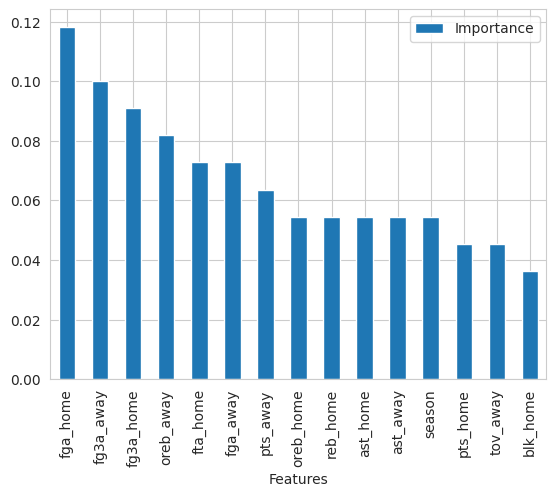

The following features were dropped by clusters_4: 
['fgm_home', 'fg3m_home', 'ftm_home', 'pf_home', 'fgm_away', 'fg3m_away', 'dreb_home', 'reb_home', 'stl_home', 'tov_home', 'ftm_away', 'fta_away', 'dreb_away', 'stl_away', 'pf_away', 'home_wins', 'play_off', 'season']

* These are the 16 most important features in descending order. The model was trained on them: 
['fg3a_home', 'plus_minus_home', 'fga_away', 'fg3a_away', 'fga_home', 'ast_home', 'oreb_home', 'reb_away', 'fta_home', 'pts_home', 'oreb_away', 'ast_away', 'pts_away', 'blk_away', 'tov_away', 'blk_home']


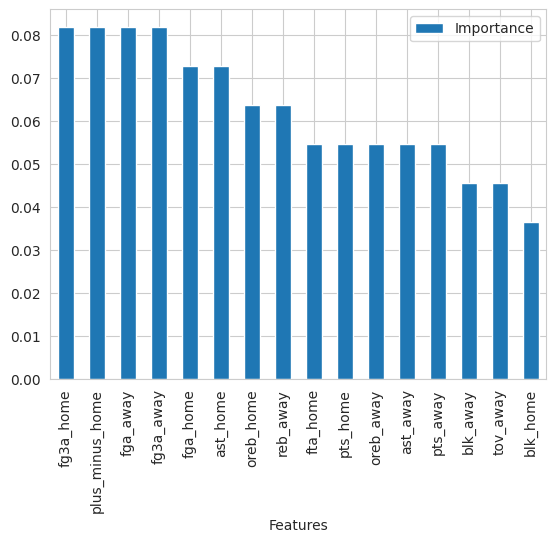

The following features were dropped by clusters_6: 
['fgm_home', 'fg3m_home', 'ftm_home', 'pf_home', 'fgm_away', 'fg3m_away', 'fta_home', 'dreb_home', 'stl_home', 'tov_home', 'ftm_away', 'fta_away', 'dreb_away', 'stl_away', 'tov_away', 'pf_away', 'home_wins', 'play_off', 'season']

* These are the 15 most important features in descending order. The model was trained on them: 
['pts_home', 'fg3a_home', 'fga_home', 'reb_home', 'ast_home', 'fga_away', 'fg3a_away', 'plus_minus_home', 'oreb_away', 'blk_away', 'oreb_home', 'blk_home', 'reb_away', 'ast_away', 'pts_away']


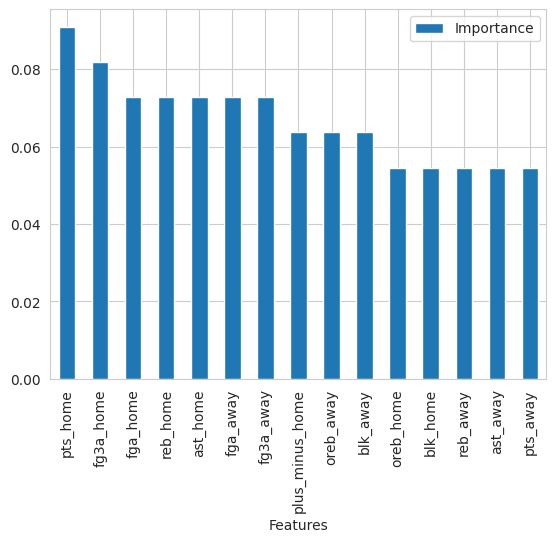

In [38]:
from src.notebook_functions import feature_importance_tree_based_models, find_features


relevant = ['clusters_3', "clusters_4", "clusters_6"]
best_features = {}
for key in relevant:
    kept, dropped = find_features(X_train[key], tuned_pipes[key], initial_drop=[])
    print(f"The following features were dropped by {key}: \n{dropped}")
    print()
    columns = X_train[key].filter(kept).columns
    ada_model = tuned_pipes[key]['model']
    feature_importance_tree_based_models(model=ada_model, columns=columns)
    best_features[key] = kept

Only the 3 cluster model kept season, so time definitely seems like it isn't relevant. I think I will try to variants, one where I drop the season and the other where I don't. This way Ican still get the season data in the cluster profile.

In [43]:
# All functions are from notebook 07 of the Churnometer walkthrough
def DescriptionAllClusters(df, name,decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop([name], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by=name)[name].unique():

        EDA_ClusterSubset = df.query(
            f"{name} == {cluster}").drop([name], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset,name, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index([name], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster,name, cluster, decimal_points):
    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:
        try:  # eventually a given cluster will have only missing data for a given variable
            if EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description
            else:
                raise ValueError(f"Wrong data type for {col}: {EDA_Cluster[col].dtypes}.")
        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")
    ClustersDescription[name] = str(cluster)
    return ClustersDescription


import plotly.express as px


def cluster_distribution_per_variable(df,name, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts([name, target]).reset_index()
    df_bar_plot.columns = [name, target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"{name} distribution across {target} levels")
    fig = px.bar(df_bar_plot, x=name, y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df[name].unique()))
    fig.show(renderer='jupyterlab')

    df_relative = (df
                   .groupby([name, target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=[name])
                   )
    df_relative.columns = [name, target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x=name, y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df[name].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='jupyterlab')


In [51]:
def report(collection,key):
    df_cluster_profile = collection[key].copy()
    relevant_features = best_features[key]+[key]
    if 'season' not in relevant_features:
        relevant_features.append('season')
    df_cluster_profile = df_cluster_profile.filter(items=relevant_features, axis=1)

    pd.set_option('display.max_colwidth', None)
    clusters_profile = DescriptionAllClusters(df_cluster_profile, key, decimal_points=0)
    return clusters_profile

report(game_many_clusters,"clusters_6")

,fga_home,fg3a_home,oreb_home,reb_home,ast_home,blk_home,pts_home,plus_minus_home,fga_away,fg3a_away,oreb_away,reb_away,ast_away,blk_away,pts_away,season
clusters_6,,,,,,,,,,,,,,,,
0,75.0 -- 84.0,10.0 -- 20.0,9.0 -- 14.0,38.0 -- 46.0,22.0 -- 29.0,3.0 -- 6.0,101.0 -- 114.0,6.0 -- 18.0,73.0 -- 81.0,10.0 -- 20.0,7.0 -- 11.0,32.0 -- 38.0,18.0 -- 24.0,2.0 -- 5.0,89.0 -- 102.0,10.0 -- 24.0
1,84.0 -- 93.0,26.0 -- 37.0,8.0 -- 13.0,41.0 -- 49.0,22.0 -- 28.0,3.0 -- 7.0,105.0 -- 120.0,-7.0 -- 10.0,85.0 -- 93.0,26.0 -- 37.0,8.0 -- 13.0,40.0 -- 48.0,21.0 -- 27.0,3.0 -- 6.0,102.0 -- 118.0,31.0 -- 35.0
2,85.0 -- 94.0,8.0 -- 19.0,15.0 -- 20.0,45.0 -- 52.0,18.0 -- 24.0,3.0 -- 7.0,92.0 -- 105.0,-8.0 -- 6.0,78.0 -- 87.0,8.0 -- 19.0,9.0 -- 14.0,39.0 -- 48.0,18.0 -- 25.0,5.0 -- 8.0,93.0 -- 106.0,7.0 -- 22.0
3,74.0 -- 82.0,11.0 -- 20.0,8.0 -- 13.0,40.0 -- 47.0,18.0 -- 25.0,5.0 -- 8.0,89.0 -- 101.0,3.0 -- 15.0,77.0 -- 86.0,11.0 -- 20.0,11.0 -- 16.0,39.0 -- 46.0,15.0 -- 20.0,3.0 -- 6.0,80.0 -- 91.0,13.0 -- 24.0
4,75.0 -- 83.0,11.0 -- 21.0,8.0 -- 12.0,34.0 -- 41.0,17.0 -- 23.0,2.0 -- 5.0,86.0 -- 99.0,-15.0 -- -5.0,74.0 -- 83.0,11.0 -- 21.0,8.0 -- 13.0,38.0 -- 46.0,20.0 -- 26.0,3.0 -- 6.0,96.0 -- 109.0,12.0 -- 25.0
5,83.0 -- 93.0,4.0 -- 13.0,11.0 -- 17.0,41.0 -- 50.0,25.0 -- 32.0,5.0 -- 9.0,109.0 -- 122.0,1.0 -- 16.0,87.0 -- 96.0,5.0 -- 13.0,13.0 -- 18.0,40.0 -- 48.0,21.0 -- 28.0,3.0 -- 6.0,100.0 -- 115.0,2.0 -- 9.0


There are many relevant features for the profiles of these clusters. We will drop all non-important features and refit the clustering and classification pipelines. Then we will look at this breakdown again and graph the distributions of these features with respect to the clusters.

## Refit Clustering This is how for I got
We now refit the clustering pipeline with the most relevant features determined by the profile in the last section. This will lead to a more focused model since it is only being trained on the features already determined to be most relevant to the clustering.

In [36]:
to_drop = [col for col in game_data.columns if col not in best_features]
new_assignments = { key: [val for val in value if val not in to_drop] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    
def last_cluster_pipe(clusters=3):
    pipe = Pipeline([('yeo_johnson',vt.YeoJohnsonTransformer(
                                    variables=new_assignments['yeo_johnson'])),
                                    ('box_cox',vt.BoxCoxTransformer(
                                    variables=new_assignments['box_cox'])),
                                    ('scaler', StandardScaler()),
                                    ('model', KMeans(n_clusters=3, 
                                                     random_state=42))])
    return pipe

game_data_reduced= game_data.copy().filter(best_features)
game_data_reduced.head()


,fga_home,fg3a_home,fta_home,oreb_home,reb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,oreb_away,ast_away,tov_away,pts_away
game_id,,,,,,,,,,,,,,
28500005,92,3,18,16,44,25,5,91,78,2,11,21,17,100
28500006,88,2,41,20,48,17,2,104,80,0,11,19,18,108
28500010,88,1,49,17,57,23,0,118,88,5,13,27,20,116
28500011,82,2,38,10,34,30,9,108,89,0,17,23,19,112
28500008,91,4,52,18,47,17,7,105,88,3,13,26,22,119


We redo the Elbow method and Silhoutte score analysis with this modified pipeline. Again, we are following the Churnometer project quite closely.

In [37]:
cluster_pipe = last_cluster_pipe()
pipeline_analysis = Pipeline(cluster_pipe.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(game_data_reduced)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


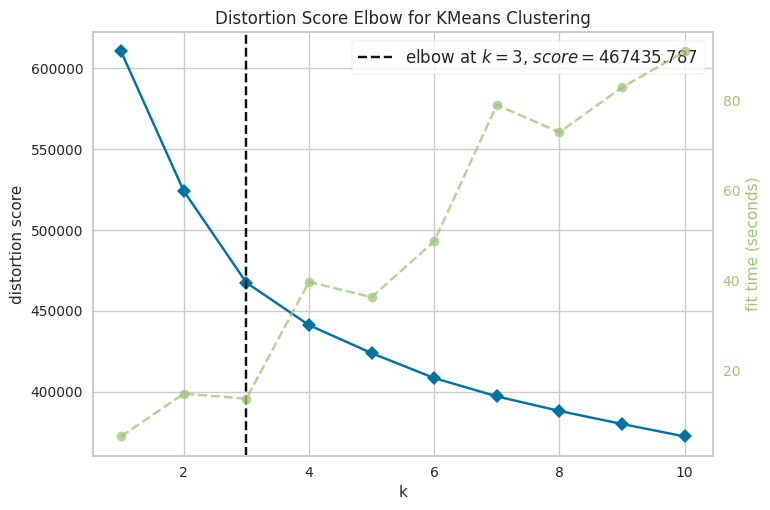

In [39]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()


=== Average Silhouette Score for different number of clusters ===


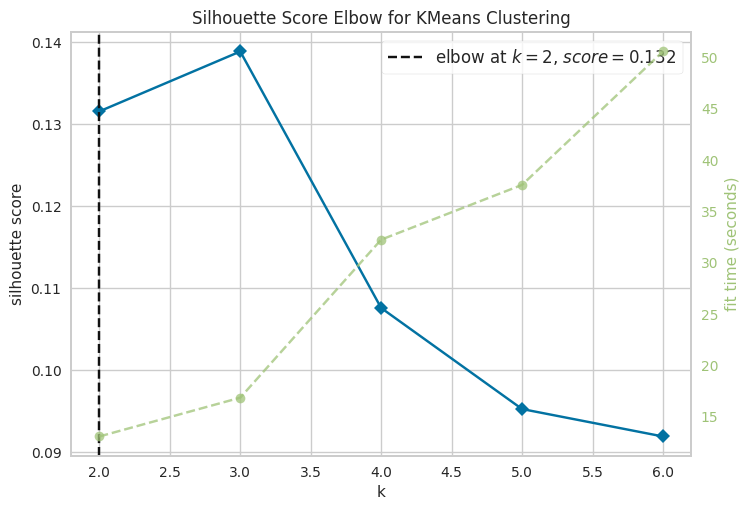



=== Silhouette plot for 2 Clusters ===


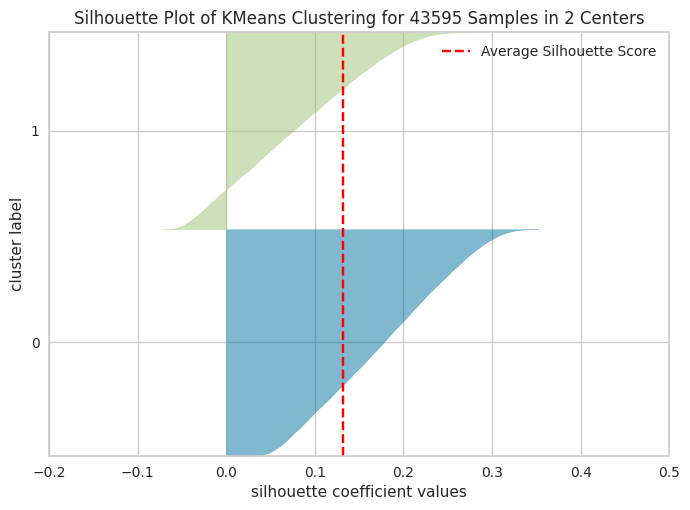



=== Silhouette plot for 3 Clusters ===


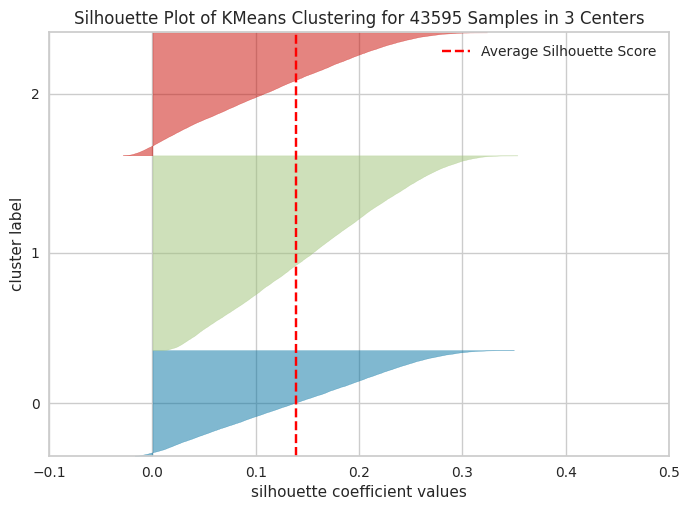



=== Silhouette plot for 4 Clusters ===


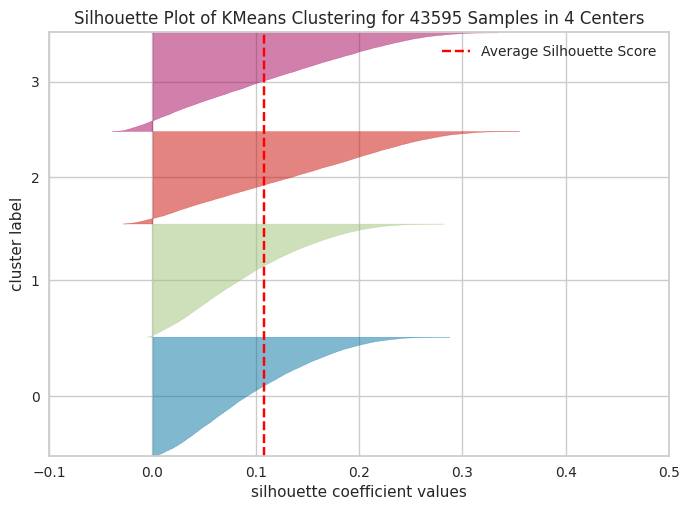



=== Silhouette plot for 5 Clusters ===


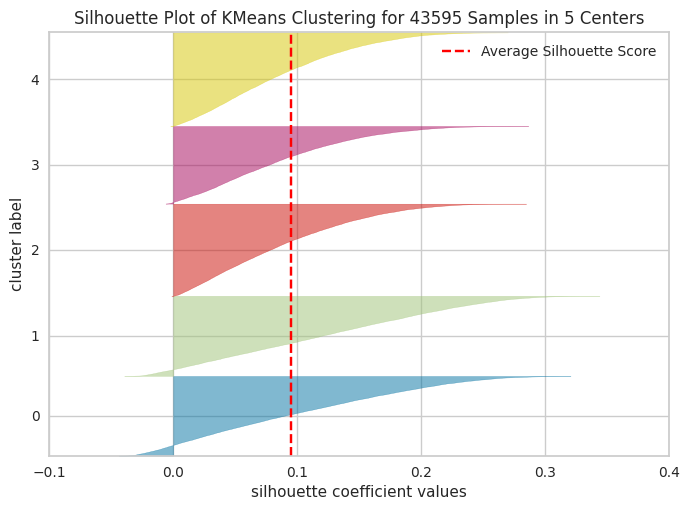



=== Silhouette plot for 6 Clusters ===


In [40]:


n_cluster_start, n_cluster_stop = 2, 7

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


Again, 3 clusters gives the highest Silhoutte coefficient.

In [ ]:
new_game_w_clusters = game_data_reduced.copy()
last_pipe = last_cluster_pipe(clusters=3)
last_pipe.fit(new_game_w_clusters)
new_game_w_clusters['Clusters'] = last_pipe.predict(new_game_w_clusters)
new_game_w_clusters.head()

,fga_home,fg3a_home,fta_home,oreb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,oreb_away,ast_away,pts_away,Clusters
game_id,,,,,,,,,,,,,
28500005,92,3,18,16,25,5,91,78,2,11,21,100,0
28500006,88,2,41,20,17,2,104,80,0,11,19,108,0
28500010,88,1,49,17,23,0,118,88,5,13,27,116,0
28500011,82,2,38,10,30,9,108,89,0,17,23,112,0
28500008,91,4,52,18,17,7,105,88,3,13,26,119,0


* Cluster frequencies 
   Clusters
2      0.46
0      0.29
1      0.24 




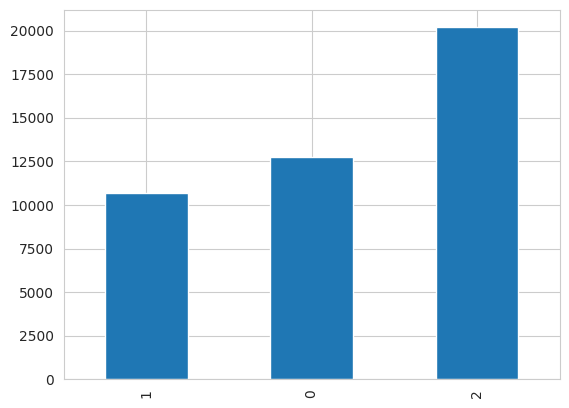

          Clusters    season
Clusters  1.000000  0.299537
season    0.299537  1.000000


In [ ]:

print(f"* Cluster frequencies \n{new_game_w_clusters['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
new_game_w_clusters['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

game_seasons = get_df('game_pre_split', 'datasets/clean/csv').filter(['game_id','season'])
game_seasons.set_index('game_id',inplace=True)
new_clusters_only = new_game_w_clusters.filter(['Clusters'])
new_season_clusters = new_clusters_only.join(game_seasons)


new_cluster_season_corr = new_season_clusters.corr()
print(new_cluster_season_corr.head())


Lets look at the distribution of seasons for each cluster like we did previously. We will compare it side by side with the old distribution. Note, the labels of the clusters may have changed so we have regruoped them by trying to match distributions.

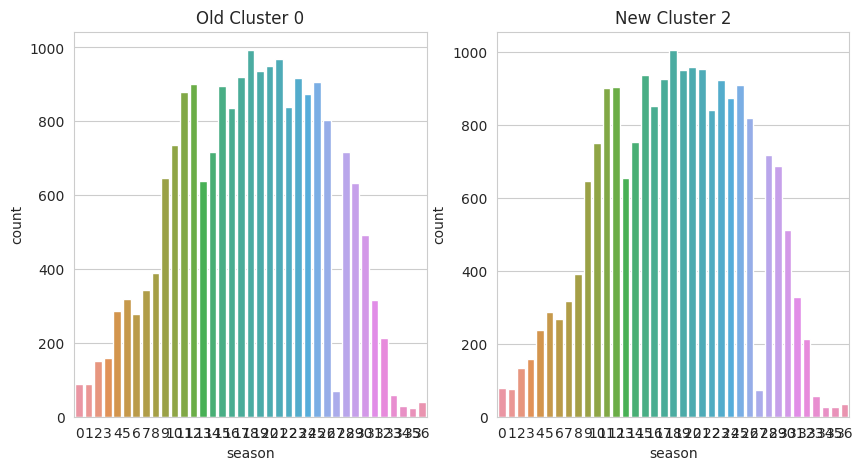

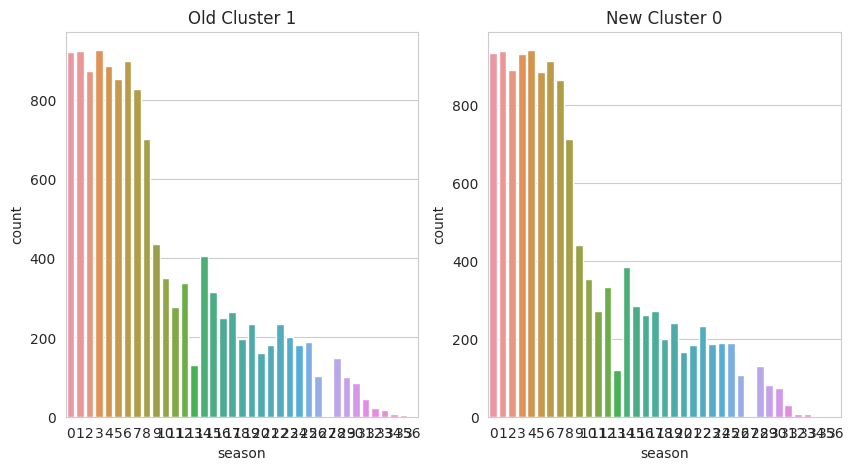

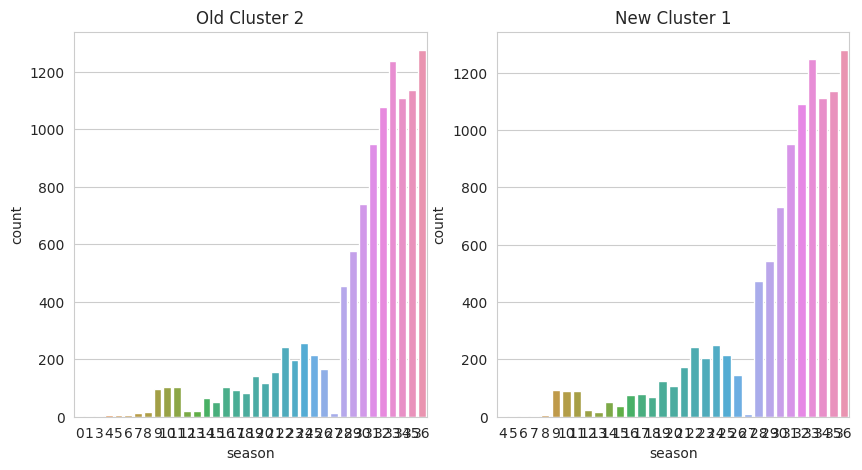

In [ ]:
pairs = [(0,2),(1,0),(2,1)]
for i,j in pairs:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    old_cluster = season_clusters.query(f'Clusters == {i}')
    new_cluster = new_season_clusters.query(f'Clusters == {j}')
    sns.countplot(data=old_cluster, x="season", ax=ax[0]).set_title(f"Old Cluster {i}")
    sns.countplot(data=new_cluster, x="season", ax=ax[1]).set_title(f"New Cluster {j}")
    plt.show()


Now we use a confusion matrix to compare the two different clusterings. Recall how the labelling has changed, so we will not see a diagonal matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

new_predictions = new_game_w_clusters['Clusters']
old_predictions = game_w_clusters['Clusters']

print(confusion_matrix(new_predictions,old_predictions))

[[  864 11417   461]
 [  515   254  9906]
 [18680  1015   483]]


The clusters have moved a bit, but not too much (if you take the relabelling into account). Let's retrain the classification pipeline on this clustering.

In [ ]:
df = new_game_w_clusters.copy()
X_train, X_test, y_train, y_test = train_test_split(
                    df.drop(['Clusters'], axis=1),
                    df['Clusters'], test_size=0.2,
                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(34876, 12)
(8719, 12)


Just to remind you, these are the input for the pipeline.

In [ ]:
to_drop = [col for col in game_data.columns if col not in best_features]
print(to_drop)
new_assignments = { key: [val for val in value if val not in to_drop] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
print(new_assignments)

['fgm_home', 'fg3m_home', 'ftm_home', 'dreb_home', 'reb_home', 'stl_home', 'tov_home', 'pf_home', 'plus_minus_home', 'fgm_away', 'fg3m_away', 'ftm_away', 'fta_away', 'dreb_away', 'reb_away', 'stl_away', 'blk_away', 'tov_away', 'pf_away', 'home_wins', 'play_off']
{'yeo_johnson': ['blk_home', 'oreb_away', 'ast_home', 'pts_away', 'pts_home', 'oreb_home'], 'box_cox': ['ast_away', 'fta_home']}


In [ ]:
ada_params = {'n_estimators': 110, 'learning_rate': 1.133,
              'algorithm': 'SAMME.R'}

def last_clf_pipe():
    model = AdaBoostClassifier(random_state=42,**ada_params)
    pipe = Pipeline([('yeo_johnson',vt.YeoJohnsonTransformer(
                                    variables=new_assignments['yeo_johnson'])),
                                    ('box_cox',vt.BoxCoxTransformer(
                                    variables=new_assignments['box_cox'])),
                                    ('scaler', StandardScaler()),
                                    ('model', model)])
    return pipe

    
last_ada_pipe = last_clf_pipe()
last_ada_pipe.fit(X_train, y_train)

print("AdaBoost:")
predicted = last_ada_pipe.predict(X_test)
print(classification_report(y_test,predicted))

AdaBoost:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2556
           1       0.95      0.98      0.96      2170
           2       0.97      0.96      0.97      3993

    accuracy                           0.96      8719
   macro avg       0.96      0.96      0.96      8719
weighted avg       0.96      0.96      0.96      8719



This is performing even better than it did previously. We will look again at the importance of different features before employing the functions above which provided the profiles for the clusters.

Old importance levels
* These are the 12 most important features in descending order. The model was trained on them: 
['fga_home', 'fg3a_home', 'fg3a_away', 'fga_away', 'fta_home', 'oreb_away', 'oreb_home', 'ast_home', 'ast_away', 'pts_home', 'pts_away', 'blk_home']


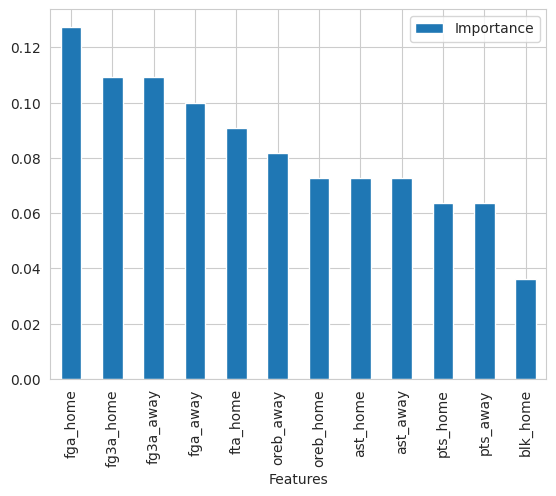

New importance levels
* These are the 12 most important features in descending order. The model was trained on them: 
['fg3a_away', 'fg3a_home', 'oreb_home', 'oreb_away', 'pts_away', 'fta_home', 'ast_home', 'fga_home', 'pts_home', 'fga_away', 'ast_away', 'blk_home']


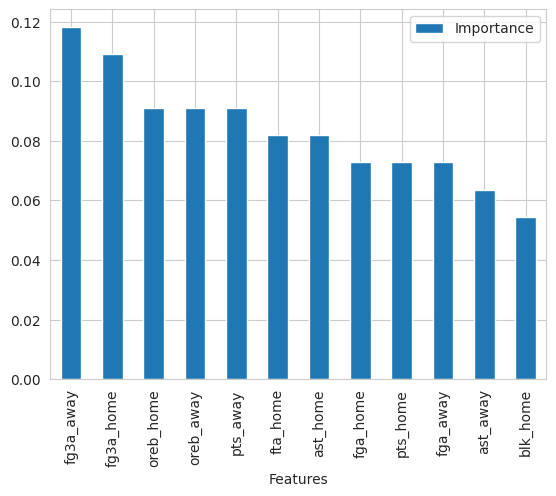

In [ ]:
print("Old importance levels")
tuned_model = tuned_ada_pipe['model']
feature_importance_tree_based_models(model=tuned_model,columns=best_features)
print("New importance levels")
ada_model = last_ada_pipe['model']
feature_importance_tree_based_models(model=ada_model, columns=best_features)

Now 3 point attempts of the away team are the most important feature.

In [ ]:
print(best_features)
new_game_w_clusters.columns

['fga_home', 'fg3a_home', 'fta_home', 'oreb_home', 'ast_home', 'blk_home', 'pts_home', 'fga_away', 'fg3a_away', 'oreb_away', 'ast_away', 'pts_away']


Index(['fga_home', 'fg3a_home', 'fta_home', 'oreb_home', 'ast_home',
       'blk_home', 'pts_home', 'fga_away', 'fg3a_away', 'oreb_away',
       'ast_away', 'pts_away', 'Clusters'],
      dtype='object')

In [ ]:
#cluster_distribution_per_variable(df, target):
df_cluster_profile = new_game_w_clusters.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)

pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df_cluster_profile, decimal_points=0)
clusters_profile

,fga_home,fg3a_home,fta_home,oreb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,oreb_away,ast_away,pts_away
Cluster,,,,,,,,,,,,
0,82.0 -- 93.0,5.0 -- 14.0,24.0 -- 35.0,11.0 -- 17.0,23.0 -- 30.0,4.0 -- 8.0,104.0 -- 118.0,83.0 -- 93.0,5.0 -- 14.0,11.0 -- 17.0,20.0 -- 27.0,98.0 -- 112.0
1,83.0 -- 92.0,24.0 -- 35.0,18.0 -- 28.0,8.0 -- 13.0,21.0 -- 28.0,3.0 -- 6.0,103.0 -- 118.0,82.0 -- 92.0,24.0 -- 35.0,7.0 -- 12.0,21.0 -- 27.0,101.0 -- 116.0
2,74.0 -- 83.0,11.0 -- 20.0,19.0 -- 30.0,9.0 -- 14.0,18.0 -- 24.0,3.0 -- 7.0,88.0 -- 102.0,74.0 -- 82.0,11.0 -- 19.0,8.0 -- 13.0,16.0 -- 23.0,85.0 -- 99.0


There are many features where two clusters have almost identical ranges. Let's look at the distribution of each feature colored by cluster.

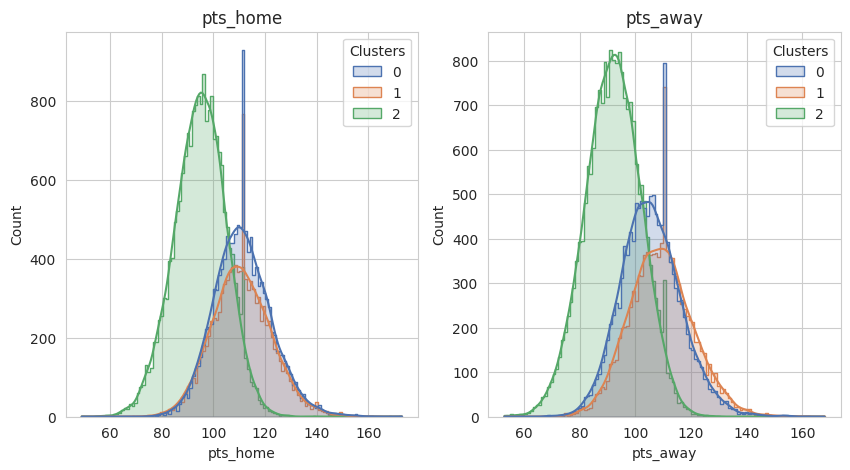

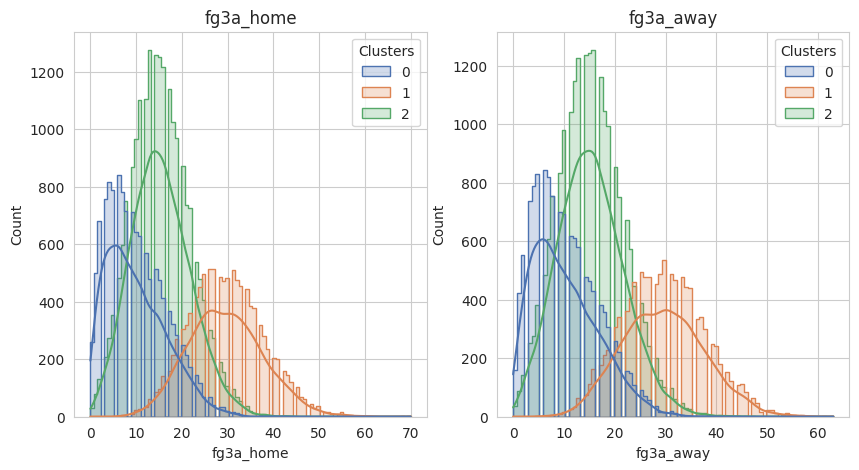

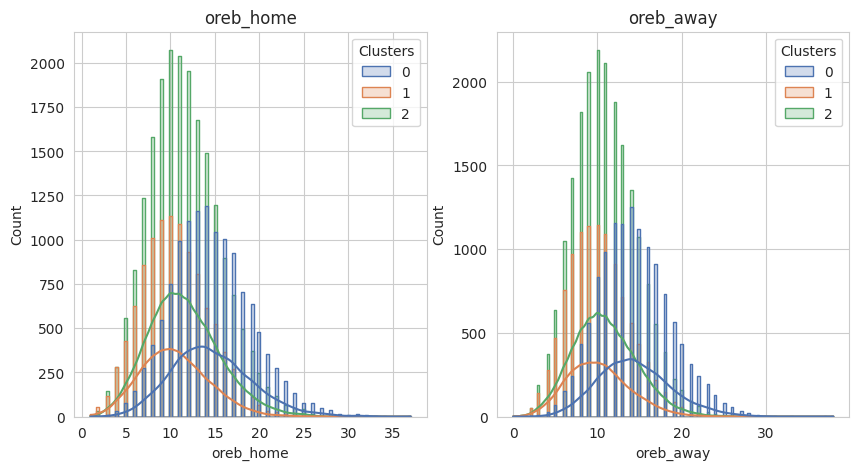

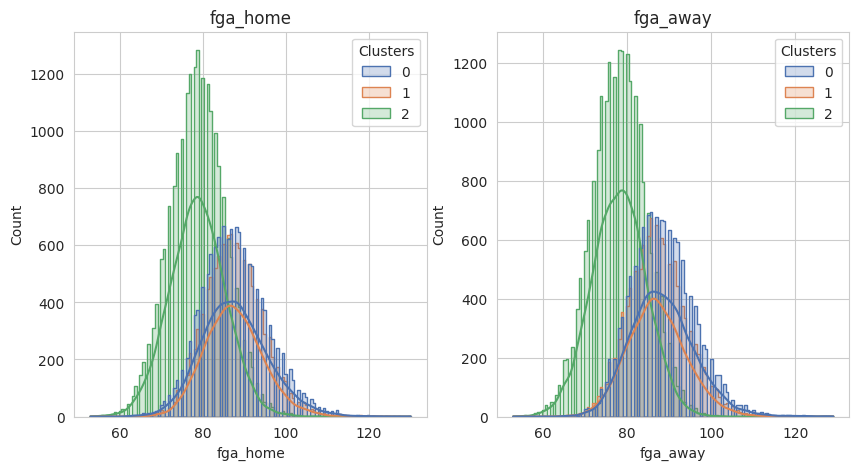

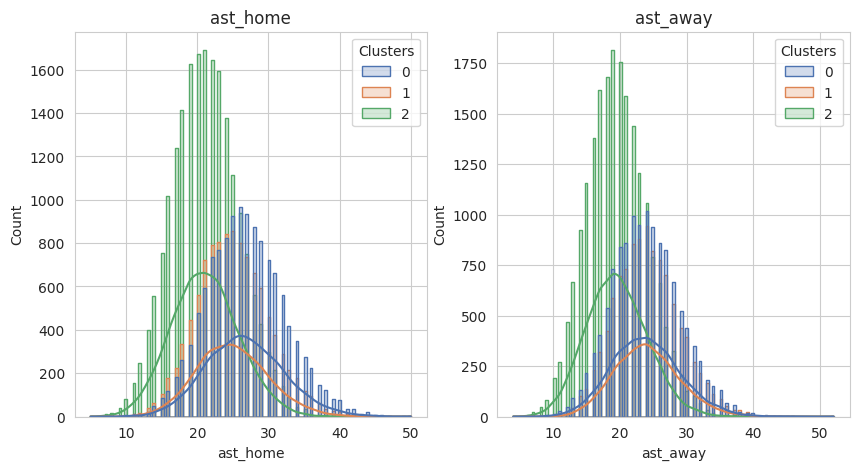

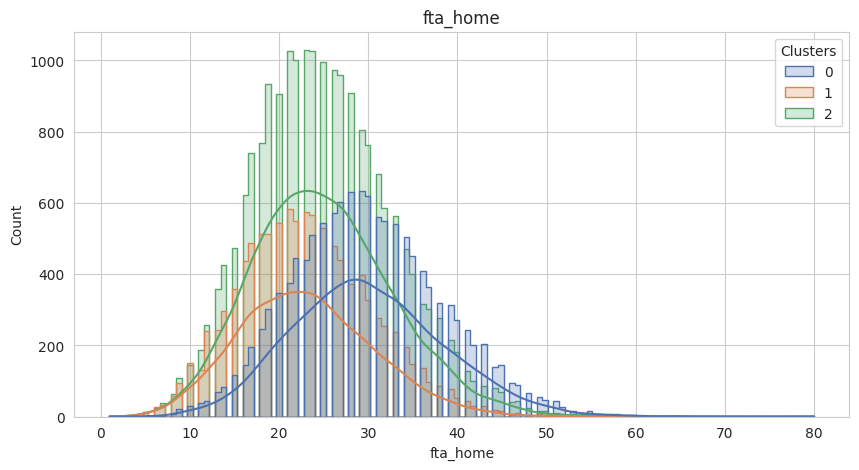

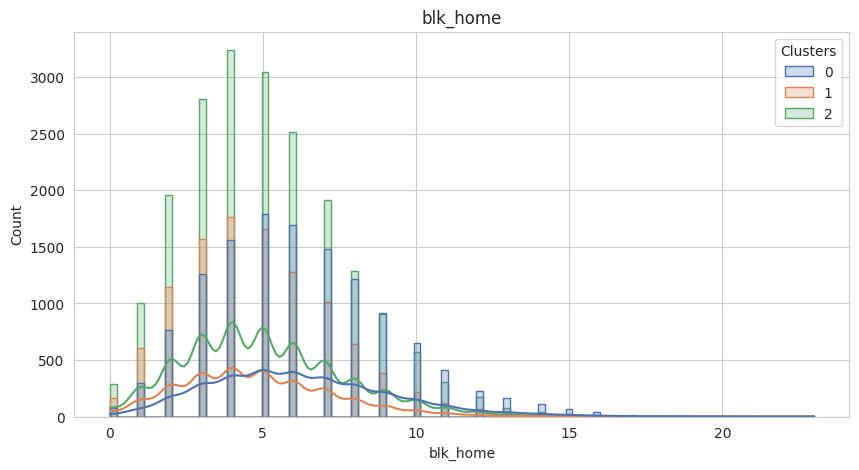

In [ ]:
feature_pairs = []
feature_stems = list({term.split('_')[0] for term in best_features})
for stem in feature_stems:
    home_stem = stem + '_home'
    away_stem = stem + '_away'
    if home_stem in best_features and away_stem in best_features:
        feature_pairs.append((home_stem, away_stem))
    elif home_stem in best_features:
        feature_pairs.append((home_stem, ''))
    elif away_stem in best_features:
        feature_pairs.append(('',away_stem))

for home, away in feature_pairs:
    if home and away:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        sns.histplot(data=df, x=home, kde=True, element="step", ax=axes[0],
                     hue='Clusters',palette='deep')
        sns.histplot(data=df, x=away, kde=True, element="step", ax=axes[1],
                     hue='Clusters', palette='deep')
        axes[0].set_title(f'{home}')
        axes[1].set_title(f'{away}')
        plt.show()
    elif home:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        sns.histplot(data=df, x=home, kde=True, element="step", ax=axes,
                     hue='Clusters', palette='deep')
        axes.set_title(f'{home}')
        plt.show()
    elif away:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        sns.histplot(data=df, x=away, kde=True, element="step", ax=axes,
                     hue='Clusters', palette='deep')
        axes.set_title(f'{away}')
        plt.show()

We see in these distributions the grouping mentioned above. Very frequently, a feature will have the same distributions over two clusters. It is a testiment to the model that it is still able to distinguish between these clusters so well.